In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

#### Here we will investigate the impact of pruning on the quality of the solutions for our problem , created in the previous part

For that part I've chosen two properties sets, which were best in the which showed the best results on previously tested architectures. That are : all properties and manually selected set of properties. Except of that, for pruning testing I've chosen two architectures : Simple Fully Connected and that with Batch Normalization.

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

D:\Anaconda\envs\ml\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


First of all let's read preprocessed data from particular files. We will devide columns of both properties sets for numerical and categorical columns. Then we will create preprocess_pipeplines for all datasets. 

In [3]:
def load_data(filename, FOLDER="./data"):
    csv_path = os.path.join(FOLDER, filename)
    return pd.read_csv(csv_path)

data = load_data("preprocessed_data.csv")
manually_selected_data = load_data("manually_selected_data.csv")

data_numerical_columns = data.select_dtypes(include=np.number).columns.tolist()
manual_data_numerical_columns = manually_selected_data.select_dtypes(include=np.number).columns.tolist()
data_categorical_columns = ['Education', 'Marital_Status']

data_numerical_columns.remove('Response')
manual_data_numerical_columns.remove('Response')

Let's define DataFrameSelector for the purpose of creating pipelines.

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import FeatureUnion

data_num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(data_numerical_columns)),
        ("imputer", SimpleImputer(strategy="median")),
    ])

data_cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(data_categorical_columns)),
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown = 'ignore')),
    ])

data_preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", data_num_pipeline),
        ("cat_pipeline", data_cat_pipeline),
    ])

manual_preprocess_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(manual_data_numerical_columns)),
         ("imputer", SimpleImputer(strategy="median")),
    ])

### Division of our datasets for data and target

In [6]:
X_data = data.drop(['Response'], axis=1)
X_manual = manually_selected_data.drop(['Response'], axis=1)
y_data = data['Response'].values
y_manual = manually_selected_data['Response'].values

### Division  of our datasets for test and train sets

In [7]:
from sklearn.model_selection import train_test_split

X_data_train, X_data_test, y_data_train, y_data_test = train_test_split(X_data, y_data, test_size = 0.3, random_state = 50)
X_manual_train, X_manual_test, y_manual_train, y_manual_test = \
            train_test_split(X_manual, y_manual, test_size = 0.3, random_state = 50)

In [8]:
data_cat_pipeline.fit_transform(X_data_train)
data_num_pipeline.fit_transform(X_data_train)

manual_preprocess_pipeline.fit_transform(X_manual_train)

array([[0.        , 0.        , 0.92929293, ..., 0.        , 0.        ,
        0.66666667],
       [0.        , 0.5       , 0.81818182, ..., 0.        , 0.        ,
        0.66666667],
       [0.        , 0.5       , 0.65656566, ..., 0.        , 0.        ,
        0.66666667],
       ...,
       [0.        , 0.5       , 0.50505051, ..., 0.        , 0.        ,
        0.66666667],
       [0.        , 0.5       , 0.88888889, ..., 0.        , 0.        ,
        1.        ],
       [0.5       , 0.        , 0.68686869, ..., 0.        , 0.        ,
        1.        ]])

In [9]:
X_data_train = torch.from_numpy(data_preprocess_pipeline.transform(X_data_train))
X_data_test = torch.from_numpy(data_preprocess_pipeline.transform(X_data_test))

X_manual_train = torch.from_numpy(manual_preprocess_pipeline.transform(X_manual_train))
X_manual_test = torch.from_numpy(manual_preprocess_pipeline.transform(X_manual_test))

###  Defining DataLoaders

In [10]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, data_list, labels):
        'Initialization'
        self.labels = labels
        self.data_list = data_list

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.data_list)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        X = self.data_list[index]
        y = self.labels[index]

        return X, y
    
data_training_set = Dataset(X_data_train, y_data_train)
data_training_generator = torch.utils.data.DataLoader(data_training_set, batch_size=64, shuffle=True)

data_validation_set = Dataset(X_data_test, y_data_test)
data_validation_generator = torch.utils.data.DataLoader(data_validation_set, batch_size=64, shuffle=False)

manual_training_set = Dataset(X_manual_train, y_manual_train)
manual_training_generator = torch.utils.data.DataLoader(manual_training_set, batch_size=64, shuffle=True)

manual_validation_set = Dataset(X_manual_test, y_manual_test)
manual_validation_generator = torch.utils.data.DataLoader(manual_validation_set, batch_size=64, shuffle=False)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

###### Previously trained models:

In [12]:
from collections import OrderedDict

class NeuralNet1(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet1, self).__init__()
        self.features = self._make_layers(input_size)
    
    def forward(self, x):
        out = self.features(x)
        return out
    
    @staticmethod
    def _make_layers(input_size):
        return nn.Sequential(OrderedDict([
          ('ln1', nn.Linear(input_size, 25)),
          ('relu1', nn.ReLU(inplace=True)),
          ('ln2', nn.Linear(25, 5)),
          ('relu2', nn.ReLU(inplace=True)),
          ('ln3', nn.Linear(5,2)),
        ]))

model_data     = NeuralNet1(33).to(device)
model_manual   = NeuralNet1(12).to(device)

In [13]:
class NeuralNetBN(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetBN, self).__init__()
        self.features = self._make_layers(input_size)
    
    def forward(self, x):
        out = self.features(x)
        return out
    
    @staticmethod
    def _make_layers(input_size):
        return nn.Sequential(OrderedDict([
          ('ln1', nn.Linear(input_size, 25)),
          ('bn1', nn.BatchNorm1d(25)),
          ('relu1', nn.ReLU(inplace=True)),
          ('ln2', nn.Linear(25, 5)),
          ('bn2', nn.BatchNorm1d(5)),
          ('relu2', nn.ReLU(inplace=True)),
          ('ln3', nn.Linear(5,2)),
        ]))
    
model_data_bn     = NeuralNetBN(33).to(device)
model_manual_bn   = NeuralNetBN(12).to(device)

## Prunning a module

### Random unstructured pruning

In that section we will choose one layer from each model and will prune its parametrs randomly unstructured

In [14]:
module_data = model_data.features[2]
module_manual = model_manual.features[2]
module_data_bn = model_data_bn.features[3]
module_manual_bn = model_manual_bn.features[3]

In [15]:
print(list(module_data.named_parameters()))

[('weight', Parameter containing:
tensor([[ 0.1629, -0.1600, -0.0857, -0.1846,  0.1354, -0.0641, -0.1726,  0.1871,
          0.1097,  0.0820, -0.0804,  0.1301,  0.0304, -0.0095, -0.0504,  0.1764,
          0.0348, -0.0684, -0.1550,  0.0882, -0.0417, -0.1449, -0.0009, -0.0410,
          0.1304],
        [-0.0301, -0.1213, -0.0615, -0.1270, -0.0785,  0.1418, -0.0079, -0.1514,
          0.1147,  0.0981, -0.1840, -0.1300, -0.0921,  0.0647, -0.0963, -0.1296,
         -0.1933,  0.1683,  0.1374, -0.0017,  0.0110,  0.1513, -0.0407, -0.1426,
         -0.1346],
        [ 0.0077, -0.0694, -0.1307, -0.1739,  0.0164, -0.0884,  0.0371,  0.1399,
         -0.0336,  0.0030, -0.1891, -0.1132, -0.1088,  0.1556, -0.1150, -0.0335,
         -0.1203,  0.0286, -0.1312,  0.0478, -0.1131, -0.1054, -0.0916,  0.0376,
          0.0442],
        [-0.1082, -0.1437,  0.1183,  0.1349, -0.0637, -0.1150, -0.1073, -0.1090,
         -0.0877,  0.0028, -0.0813,  0.0292, -0.1591,  0.0399, -0.0241,  0.0629,
         -0.0073, 

In [16]:
print(list(module_data.named_buffers()))

[]


In [17]:
from torch.nn.utils import prune 

prune.random_unstructured(module_data, name="weight", amount=0.3)
prune.random_unstructured(module_manual, name="weight", amount=0.3)
prune.random_unstructured(module_data_bn, name="weight", amount=0.3)
prune.random_unstructured(module_manual_bn, name="weight", amount=0.3)

Linear(in_features=25, out_features=5, bias=True)

In [18]:
print(list(model_manual.features[2].named_buffers()))
print(list(model_data.features[2].named_buffers()))

[('weight_mask', tensor([[1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
         0., 0., 0., 1., 0., 1., 1.],
        [0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1.,
         1., 0., 1., 0., 1., 1., 1.],
        [1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1.,
         1., 0., 1., 0., 1., 1., 1.],
        [0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
         0., 0., 1., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
         0., 1., 1., 1., 1., 1., 0.]]))]
[('weight_mask', tensor([[1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
         0., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
         1., 0., 1., 0., 1., 1., 1.],
        [1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1.,
         0., 1., 0., 0., 0., 0., 1.],
        [0.

In [19]:
print(list(model_manual_bn.features[3].named_buffers()))
print(list(model_data_bn.features[3].named_buffers()))

[('weight_mask', tensor([[0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 1., 0.],
        [1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
         1., 0., 0., 1., 1., 0., 0.],
        [1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
         1., 1., 0., 1., 1., 1., 1.],
        [1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1.],
        [1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1.,
         0., 1., 0., 1., 1., 0., 1.]]))]
[('weight_mask', tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1.,
         1., 1., 1., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1.,
         1., 1., 0., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1.,
         1., 1., 0., 1., 1., 1., 1.],
        [1.

#### Now we will create a special class with a method containing learning loop 

While training the following metrics will be reported: \
    - loss \
    - accuracy \
    - test loss - loss on a test set \
    - test accuracy - accuracy on a test set
    - recall \
    - precision \
    - test recall \
    - test precision 

In [20]:
class TrainTestModel:
    def __init__(self, model, num_epochs = 20, learning_rate = 0.001):
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.history = {'acc':[], 'val_acc':[], 'loss':[], 'val_loss':[]}
        
    def get_history(self):
        return self.history
        
    def train(self, train_loader, test_loader):
         for epoch in range(self.num_epochs):
            
            true_positives = 0
            false_positives = 0
            false_negatives = 0
            
            all_loss = 0
            correct_answers = 0
            all_inputs = 0
            minibatches_number = 0

            for i, (customers, labels) in enumerate(train_loader):
                # Forward pass
                output = self.model(customers.float())
                loss = self.criterion(output, labels)

                # Backprpagation and optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                _, predicted = torch.max(output.data, 1)
                
                actual_correct = predicted.eq(labels.data).cpu().sum()
                
                true_positives += len([x for x, y in zip(predicted, labels) if x==1 and y==1])
                false_positives += len([x for x, y in zip(predicted, labels) if x==1 and y==0])
                false_negatives += len([x for x, y in zip(predicted, labels) if x==0 and y==1])

                all_inputs += labels.size(0)
                correct_answers += actual_correct
                all_loss += loss.item()
                minibatches_number += 1
                
                if true_positives+false_negatives != 0:
                    recall = true_positives/(true_positives+false_negatives)
                else:
                    recall = 0
                    
                if true_positives+false_positives != 0:
                    precision = true_positives/(true_positives+false_positives)
                else:
                    precision = 0
        
                if (i+1)%10 == 0:
                    print(f'[epoch {epoch}] train loss: {all_loss / minibatches_number :.3f} | train acc: {100. * correct_answers / all_inputs :.3f}%')
                    print(f'[epoch {epoch}] recall: {recall:.3f} | precision: {precision :.3f}')
            
            self.history['acc'].append(100. * correct_answers / all_inputs)
            self.history['loss'].append(all_loss / minibatches_number)
            
            true_positives = 0
            false_positives = 0
            false_negatives = 0
            
            all_loss = 0
            correct_answers = 0
            all_inputs = 0
            minibatches_number = 0
            
            for customers, labels in test_loader:
                          
                outputs = self.model(customers.float())
                _, predicted = torch.max(outputs.data, 1)

                loss = self.criterion(outputs, labels)
                
                actual_correct = predicted.eq(labels.data).cpu().sum()
                actual_input = labels.size(0)
                
                true_positives += len([x for x, y in zip(predicted, labels) if x==1 and y==1])
                false_positives += len([x for x, y in zip(predicted, labels) if x==1 and y==0])
                false_negatives += len([x for x, y in zip(predicted, labels) if x==0 and y==1])
                
                if true_positives+false_negatives != 0:
                    recall = true_positives/(true_positives+false_negatives)
                else:
                    recall = 0
                    
                if true_positives+false_positives != 0:
                    precision = true_positives/(true_positives+false_positives)
                else:
                    precision = 0
                
                all_inputs += actual_input
                correct_answers += actual_correct
                all_loss += loss.item()
                minibatches_number += 1
                
                
  
            print(f'[epoch {epoch}] test loss: {all_loss/minibatches_number :.3f} | test acc: {100. * correct_answers / all_inputs :.3f}%')
            print(f'[epoch {epoch}] test recall: {recall :.3f} | test precision: {precision :.3f}')
            self.history['val_acc'].append(100. * correct_answers / all_inputs)
            self.history['val_loss'].append(all_loss / minibatches_number)

##### Training pruned models

In [21]:
traintest_data = TrainTestModel(model_data)
traintest_manual = TrainTestModel(model_manual)
traintest_data_bn = TrainTestModel(model_data_bn)
traintest_manual_bn = TrainTestModel(model_manual_bn)

In [22]:
traintest_data.train(data_training_generator, data_validation_generator)

[epoch 0] train loss: 0.571 | train acc: 85.938%
[epoch 0] recall: 0.000 | precision: 0.000
[epoch 0] train loss: 0.572 | train acc: 84.453%
[epoch 0] recall: 0.000 | precision: 0.000
[epoch 0] test loss: 0.541 | test acc: 86.438%
[epoch 0] test recall: 0.000 | test precision: 0.000
[epoch 1] train loss: 0.537 | train acc: 85.312%
[epoch 1] recall: 0.000 | precision: 0.000
[epoch 1] train loss: 0.532 | train acc: 84.531%
[epoch 1] recall: 0.000 | precision: 0.000
[epoch 1] test loss: 0.484 | test acc: 86.438%
[epoch 1] test recall: 0.000 | test precision: 0.000
[epoch 2] train loss: 0.482 | train acc: 85.156%
[epoch 2] recall: 0.000 | precision: 0.000
[epoch 2] train loss: 0.472 | train acc: 84.844%
[epoch 2] recall: 0.000 | precision: 0.000
[epoch 2] test loss: 0.420 | test acc: 86.438%
[epoch 2] test recall: 0.000 | test precision: 0.000
[epoch 3] train loss: 0.436 | train acc: 84.531%
[epoch 3] recall: 0.000 | precision: 0.000
[epoch 3] train loss: 0.430 | train acc: 84.531%
[epoch 

In [23]:
traintest_manual.train(manual_training_generator, manual_validation_generator)

[epoch 0] train loss: 0.739 | train acc: 13.750%
[epoch 0] recall: 0.978 | precision: 0.137
[epoch 0] train loss: 0.717 | train acc: 27.969%
[epoch 0] recall: 0.777 | precision: 0.142
[epoch 0] test loss: 0.653 | test acc: 86.438%
[epoch 0] test recall: 0.000 | test precision: 0.000
[epoch 1] train loss: 0.640 | train acc: 82.969%
[epoch 1] recall: 0.000 | precision: 0.000
[epoch 1] train loss: 0.620 | train acc: 83.828%
[epoch 1] recall: 0.000 | precision: 0.000
[epoch 1] test loss: 0.552 | test acc: 86.438%
[epoch 1] test recall: 0.000 | test precision: 0.000
[epoch 2] train loss: 0.532 | train acc: 87.031%
[epoch 2] recall: 0.000 | precision: 0.000
[epoch 2] train loss: 0.529 | train acc: 84.688%
[epoch 2] recall: 0.000 | precision: 0.000
[epoch 2] test loss: 0.461 | test acc: 86.438%
[epoch 2] test recall: 0.000 | test precision: 0.000
[epoch 3] train loss: 0.483 | train acc: 82.812%
[epoch 3] recall: 0.000 | precision: 0.000
[epoch 3] train loss: 0.456 | train acc: 84.375%
[epoch 

In [24]:
traintest_manual_bn.train(manual_training_generator, manual_validation_generator)

[epoch 0] train loss: 0.659 | train acc: 54.375%
[epoch 0] recall: 0.510 | precision: 0.180
[epoch 0] train loss: 0.642 | train acc: 62.188%
[epoch 0] recall: 0.493 | precision: 0.212
[epoch 0] test loss: 0.554 | test acc: 78.092%
[epoch 0] test recall: 0.516 | test precision: 0.313
[epoch 1] train loss: 0.574 | train acc: 77.031%
[epoch 1] recall: 0.469 | precision: 0.326
[epoch 1] train loss: 0.553 | train acc: 78.672%
[epoch 1] recall: 0.482 | precision: 0.346
[epoch 1] test loss: 0.488 | test acc: 82.712%
[epoch 1] test recall: 0.538 | test precision: 0.398
[epoch 2] train loss: 0.511 | train acc: 80.469%
[epoch 2] recall: 0.422 | precision: 0.394
[epoch 2] train loss: 0.496 | train acc: 80.859%
[epoch 2] recall: 0.463 | precision: 0.409
[epoch 2] test loss: 0.442 | test acc: 85.395%
[epoch 2] test recall: 0.527 | test precision: 0.466
[epoch 3] train loss: 0.459 | train acc: 83.750%
[epoch 3] recall: 0.461 | precision: 0.490
[epoch 3] train loss: 0.454 | train acc: 83.750%
[epoch 

In [25]:
traintest_data_bn.train(data_training_generator, data_validation_generator)

[epoch 0] train loss: 0.634 | train acc: 70.781%
[epoch 0] recall: 0.295 | precision: 0.215
[epoch 0] train loss: 0.609 | train acc: 75.156%
[epoch 0] recall: 0.320 | precision: 0.255
[epoch 0] test loss: 0.558 | test acc: 81.222%
[epoch 0] test recall: 0.308 | test precision: 0.308
[epoch 1] train loss: 0.545 | train acc: 83.125%
[epoch 1] recall: 0.340 | precision: 0.486
[epoch 1] train loss: 0.538 | train acc: 83.594%
[epoch 1] recall: 0.307 | precision: 0.470
[epoch 1] test loss: 0.501 | test acc: 85.395%
[epoch 1] test recall: 0.308 | test precision: 0.444
[epoch 2] train loss: 0.502 | train acc: 84.688%
[epoch 2] recall: 0.280 | precision: 0.519
[epoch 2] train loss: 0.494 | train acc: 85.000%
[epoch 2] recall: 0.276 | precision: 0.554
[epoch 2] test loss: 0.461 | test acc: 87.779%
[epoch 2] test recall: 0.330 | test precision: 0.588
[epoch 3] train loss: 0.464 | train acc: 86.875%
[epoch 3] recall: 0.317 | precision: 0.717
[epoch 3] train loss: 0.454 | train acc: 87.266%
[epoch 

So, the models showed the following results

Simple Fully Connected architecture:

   All properties set: \
    - test loss: 0.266 \
    - test acc: 86.438%  
    - test recall: 0.000 \
    - test precision: 0.000 \
   Manually selected set: \
    - test loss: 0.282 \
    - test acc: 90.015% 
    - test recall: 0.418 \
    - test precision: 0.731 
   
Fully Connected architecture with Batch Normalization: \ 
    All properties set: \
    - test loss: 0.284 \
    - test acc: 89.866% \
    - test recall: 0.440 \
    - test precision: 0.702 \
   Manually selected set: \
    - test loss: 0.274 \
    - test acc: 89.568%  
    - test recall: 0.505 \
    - test precision: 0.648 \
    
In general, pruning improved both accuracy (especially for manually selected data) and recall, but in the first case it apparently had a negative impact because the model simply learned to answer one answer for each input

In [26]:
history_data = traintest_data.get_history()
history_manual = traintest_manual.get_history()
history_data_bn = traintest_data_bn.get_history()
history_manual_bn = traintest_manual_bn.get_history()

####  Loss curves for all properties dataset 

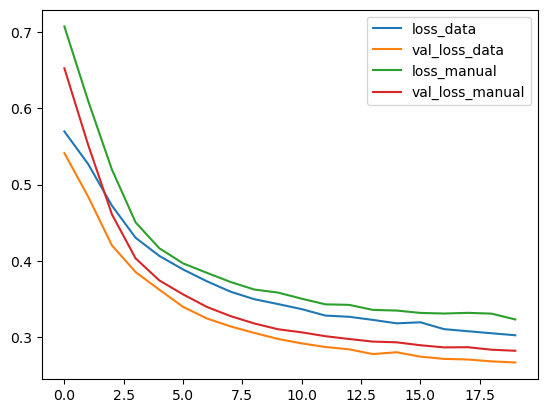

In [27]:
import matplotlib.pyplot as plt

plt.plot(pd.DataFrame(history_data['loss']), label='loss_data')
plt.plot(pd.DataFrame(history_data['val_loss']), label='val_loss_data')
plt.plot(pd.DataFrame(history_manual['loss']), label='loss_manual')
plt.plot(pd.DataFrame(history_manual['val_loss']), label='val_loss_manual')

plt.legend()
plt.show()

####  Loss curves for manually selected properties dataset 

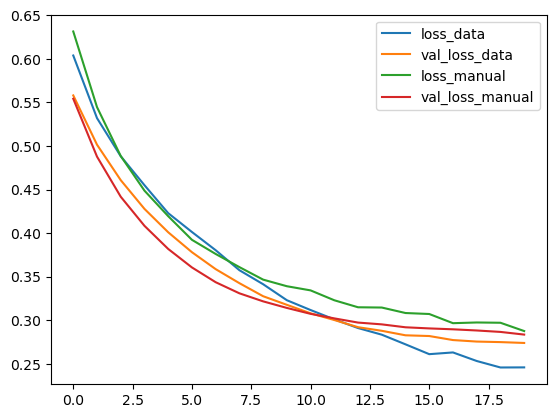

In [28]:
import matplotlib.pyplot as plt

plt.plot(pd.DataFrame(history_data_bn['loss']), label='loss_data')
plt.plot(pd.DataFrame(history_data_bn['val_loss']), label='val_loss_data')
plt.plot(pd.DataFrame(history_manual_bn['loss']), label='loss_manual')
plt.plot(pd.DataFrame(history_manual_bn['val_loss']), label='val_loss_manual')

plt.legend()
plt.show()

### Iterative prunning

In that section we will choose one layer from each model and will prune its parametrs iteratively and structured

In [29]:
model_data_it     = NeuralNet1(33).to(device)
model_manual_it   = NeuralNet1(12).to(device)
model_data_it_bn     = NeuralNetBN(33).to(device)
model_manual_it_bn   = NeuralNetBN(12).to(device)

In [30]:
module_data_it = model_data_it.features[2]
module_manual_it = model_manual_it.features[2]
module_data_it_bn = model_data_it_bn.features[3]
module_manual_it_bn = model_manual_it_bn.features[3]

In [ ]:
prune.ln_structured(module_data_it, name="weight", amount=0.5, n=3, dim=0)
prune.ln_structured(module_manual_it, name="weight", amount=0.5, n=3, dim=0)
prune.ln_structured(module_data_it_bn, name="weight", amount=0.5, n=3, dim=0)
prune.ln_structured(module_manual_it_bn, name="weight", amount=0.5, n=3, dim=0)

##### Training pruned models

In [32]:
traintest_data_it = TrainTestModel(model_data_it)
traintest_manual_it = TrainTestModel(model_manual_it)
traintest_data_it_bn = TrainTestModel(model_data_it_bn)
traintest_manual_it_bn = TrainTestModel(model_manual_it_bn)

traintest_data_it.train(data_training_generator, data_validation_generator)

[epoch 0] train loss: 0.673 | train acc: 83.125%
[epoch 0] recall: 0.000 | precision: 0.000
[epoch 0] train loss: 0.665 | train acc: 84.531%
[epoch 0] recall: 0.000 | precision: 0.000
[epoch 0] test loss: 0.646 | test acc: 86.438%
[epoch 0] test recall: 0.000 | test precision: 0.000
[epoch 1] train loss: 0.644 | train acc: 84.844%
[epoch 1] recall: 0.000 | precision: 0.000
[epoch 1] train loss: 0.638 | train acc: 84.844%
[epoch 1] recall: 0.000 | precision: 0.000
[epoch 1] test loss: 0.615 | test acc: 86.438%
[epoch 1] test recall: 0.000 | test precision: 0.000
[epoch 2] train loss: 0.612 | train acc: 83.750%
[epoch 2] recall: 0.000 | precision: 0.000
[epoch 2] train loss: 0.600 | train acc: 84.531%
[epoch 2] recall: 0.000 | precision: 0.000
[epoch 2] test loss: 0.555 | test acc: 86.438%
[epoch 2] test recall: 0.000 | test precision: 0.000
[epoch 3] train loss: 0.539 | train acc: 86.719%
[epoch 3] recall: 0.000 | precision: 0.000
[epoch 3] train loss: 0.535 | train acc: 84.609%
[epoch 

In [33]:
traintest_manual_it.train(manual_training_generator, manual_validation_generator)

[epoch 0] train loss: 0.634 | train acc: 85.000%
[epoch 0] recall: 0.000 | precision: 0.000
[epoch 0] train loss: 0.629 | train acc: 84.688%
[epoch 0] recall: 0.000 | precision: 0.000
[epoch 0] test loss: 0.611 | test acc: 86.438%
[epoch 0] test recall: 0.000 | test precision: 0.000
[epoch 1] train loss: 0.612 | train acc: 84.375%
[epoch 1] recall: 0.000 | precision: 0.000
[epoch 1] train loss: 0.607 | train acc: 84.688%
[epoch 1] recall: 0.000 | precision: 0.000
[epoch 1] test loss: 0.588 | test acc: 86.438%
[epoch 1] test recall: 0.000 | test precision: 0.000
[epoch 2] train loss: 0.593 | train acc: 83.281%
[epoch 2] recall: 0.000 | precision: 0.000
[epoch 2] train loss: 0.587 | train acc: 84.531%
[epoch 2] recall: 0.000 | precision: 0.000
[epoch 2] test loss: 0.566 | test acc: 86.438%
[epoch 2] test recall: 0.000 | test precision: 0.000
[epoch 3] train loss: 0.574 | train acc: 83.438%
[epoch 3] recall: 0.000 | precision: 0.000
[epoch 3] train loss: 0.569 | train acc: 83.906%
[epoch 

In [34]:
traintest_data_it_bn.train(data_training_generator, data_validation_generator)

[epoch 0] train loss: 0.840 | train acc: 16.406%
[epoch 0] recall: 0.961 | precision: 0.156
[epoch 0] train loss: 0.829 | train acc: 17.266%
[epoch 0] recall: 0.963 | precision: 0.146
[epoch 0] test loss: 0.774 | test acc: 27.273%
[epoch 0] test recall: 0.923 | test precision: 0.149
[epoch 1] train loss: 0.761 | train acc: 33.438%
[epoch 1] recall: 0.948 | precision: 0.179
[epoch 1] train loss: 0.740 | train acc: 36.406%
[epoch 1] recall: 0.938 | precision: 0.184
[epoch 1] test loss: 0.706 | test acc: 43.815%
[epoch 1] test recall: 0.868 | test precision: 0.178
[epoch 2] train loss: 0.689 | train acc: 49.062%
[epoch 2] recall: 0.870 | precision: 0.217
[epoch 2] train loss: 0.680 | train acc: 51.094%
[epoch 2] recall: 0.882 | precision: 0.229
[epoch 2] test loss: 0.656 | test acc: 53.651%
[epoch 2] test recall: 0.835 | test precision: 0.204
[epoch 3] train loss: 0.643 | train acc: 68.281%
[epoch 3] recall: 0.827 | precision: 0.317
[epoch 3] train loss: 0.635 | train acc: 74.453%
[epoch 

In [35]:
traintest_manual_it_bn.train(manual_training_generator, manual_validation_generator)

[epoch 0] train loss: 0.612 | train acc: 75.312%
[epoch 0] recall: 0.567 | precision: 0.300
[epoch 0] train loss: 0.596 | train acc: 77.109%
[epoch 0] recall: 0.536 | precision: 0.336
[epoch 0] test loss: 0.555 | test acc: 83.010%
[epoch 0] test recall: 0.495 | test precision: 0.398
[epoch 1] train loss: 0.544 | train acc: 84.531%
[epoch 1] recall: 0.512 | precision: 0.436
[epoch 1] train loss: 0.538 | train acc: 84.219%
[epoch 1] recall: 0.439 | precision: 0.483
[epoch 1] test loss: 0.513 | test acc: 86.438%
[epoch 1] test recall: 0.505 | test precision: 0.500
[epoch 2] train loss: 0.519 | train acc: 84.062%
[epoch 2] recall: 0.421 | precision: 0.529
[epoch 2] train loss: 0.503 | train acc: 86.094%
[epoch 2] recall: 0.439 | precision: 0.588
[epoch 2] test loss: 0.484 | test acc: 88.077%
[epoch 2] test recall: 0.484 | test precision: 0.571
[epoch 3] train loss: 0.474 | train acc: 87.656%
[epoch 3] recall: 0.480 | precision: 0.653
[epoch 3] train loss: 0.470 | train acc: 87.109%
[epoch 

So, the models showed the following results

Simple Fully Connected architecture:

   All properties set: \
    - test loss: 0.248 \
    - test acc: 90.611%  
    - test recall: 0.571 \
    - test precision: 0.684 \
   Manually selected set: \
    - test loss: 0.331 \
    - test acc: 90.015% \
    - test recall: 0.407 \
    - test precision: 0.740 
   
Fully Connected architecture with Batch Normalization: \ 
    All properties set: \
    - test loss: 0.284\
    - test acc: 90.462% \
    - test recall: 0.495 \
    - test precision: 0.714 \
   Manually selected set: \
    - test loss: 0.305 \
    - test acc: 89.121%  
    - test recall: 0.330 \
    - test precision: 0.714 
    
Those results are similar to previos ones, they improved both accuracy (especially for manually selected data) and recall as well, but we don't see the negative impact of pruning as in the random unstructured implementation.

In [36]:
history_data_it = traintest_data_it.get_history()
history_manual_it = traintest_manual_it.get_history()
history_data_it_bn = traintest_data_it_bn.get_history()
history_manual_it_bn = traintest_manual_it_bn.get_history()

####  Loss curves for all properties dataset 

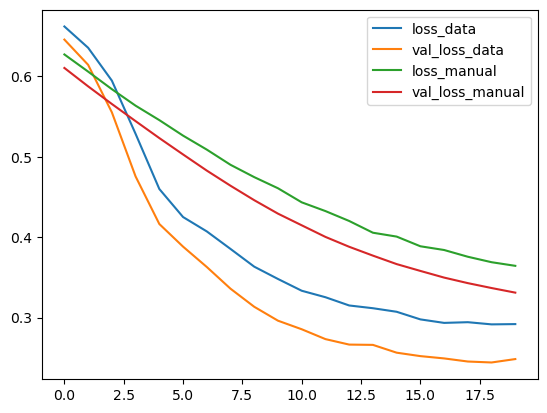

In [37]:
import matplotlib.pyplot as plt

plt.plot(pd.DataFrame(history_data_it['loss']), label='loss_data')
plt.plot(pd.DataFrame(history_data_it['val_loss']), label='val_loss_data')
plt.plot(pd.DataFrame(history_manual_it['loss']), label='loss_manual')
plt.plot(pd.DataFrame(history_manual_it['val_loss']), label='val_loss_manual')

plt.legend()
plt.show()

####  Loss curves for manually selected properties data set 

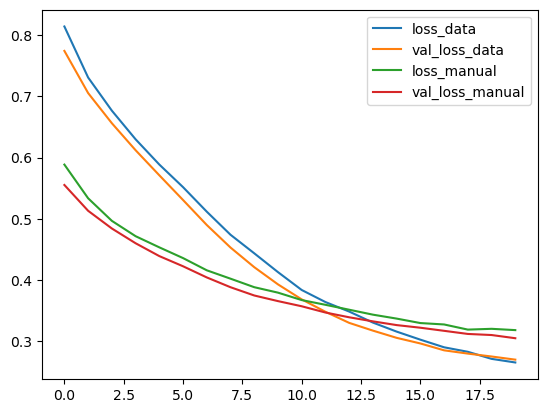

In [38]:
import matplotlib.pyplot as plt

plt.plot(pd.DataFrame(history_data_it_bn['loss']), label='loss_data')
plt.plot(pd.DataFrame(history_data_it_bn['val_loss']), label='val_loss_data')
plt.plot(pd.DataFrame(history_manual_it_bn['loss']), label='loss_manual')
plt.plot(pd.DataFrame(history_manual_it_bn['val_loss']), label='val_loss_manual')

plt.legend()
plt.show()

### Pruning multiple parameters

In that section we will prune all layers of the model with an unstructured method 

In [39]:
def pruneAllLayers(model):
    for name, module in model.named_modules():
        # prune 40% of all Linear layers 
        if isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=0.4)

In [40]:
model_data_all     = NeuralNet1(33).to(device)
model_manual_all   = NeuralNet1(12).to(device)
model_data_all_bn     = NeuralNetBN(33).to(device)
model_manual_all_bn   = NeuralNetBN(12).to(device)

pruneAllLayers(model_data_all)
pruneAllLayers(model_manual_all)
pruneAllLayers(model_data_all_bn)
pruneAllLayers(model_manual_all_bn)

print(dict(model_data_all.named_buffers()).keys())  # to verify that all masks exist
print(dict(model_manual_all.named_buffers()).keys())  # to verify that all masks exist
print(dict(model_data_all_bn.named_buffers()).keys())  # to verify that all masks exist
print(dict(model_manual_all_bn.named_buffers()).keys())  # to verify that all masks exist

dict_keys(['features.ln1.weight_mask', 'features.ln2.weight_mask', 'features.ln3.weight_mask'])
dict_keys(['features.ln1.weight_mask', 'features.ln2.weight_mask', 'features.ln3.weight_mask'])
dict_keys(['features.ln1.weight_mask', 'features.bn1.running_mean', 'features.bn1.running_var', 'features.bn1.num_batches_tracked', 'features.ln2.weight_mask', 'features.bn2.running_mean', 'features.bn2.running_var', 'features.bn2.num_batches_tracked', 'features.ln3.weight_mask'])
dict_keys(['features.ln1.weight_mask', 'features.bn1.running_mean', 'features.bn1.running_var', 'features.bn1.num_batches_tracked', 'features.ln2.weight_mask', 'features.bn2.running_mean', 'features.bn2.running_var', 'features.bn2.num_batches_tracked', 'features.ln3.weight_mask'])


##### Training pruned models

In [41]:
traintest_data_all = TrainTestModel(model_data_all)
traintest_manual_all = TrainTestModel(model_manual_all)
traintest_data_all_bn = TrainTestModel(model_data_all_bn)
traintest_manual_all_bn = TrainTestModel(model_manual_all_bn)

traintest_data_all.train(data_training_generator, data_validation_generator)

[epoch 0] train loss: 0.642 | train acc: 85.156%
[epoch 0] recall: 0.000 | precision: 0.000
[epoch 0] train loss: 0.634 | train acc: 84.297%
[epoch 0] recall: 0.000 | precision: 0.000
[epoch 0] test loss: 0.597 | test acc: 86.438%
[epoch 0] test recall: 0.000 | test precision: 0.000
[epoch 1] train loss: 0.593 | train acc: 84.219%
[epoch 1] recall: 0.000 | precision: 0.000
[epoch 1] train loss: 0.584 | train acc: 83.984%
[epoch 1] recall: 0.000 | precision: 0.000
[epoch 1] test loss: 0.539 | test acc: 86.438%
[epoch 1] test recall: 0.000 | test precision: 0.000
[epoch 2] train loss: 0.530 | train acc: 85.781%
[epoch 2] recall: 0.000 | precision: 0.000
[epoch 2] train loss: 0.520 | train acc: 84.922%
[epoch 2] recall: 0.000 | precision: 0.000
[epoch 2] test loss: 0.470 | test acc: 86.438%
[epoch 2] test recall: 0.000 | test precision: 0.000
[epoch 3] train loss: 0.469 | train acc: 85.156%
[epoch 3] recall: 0.000 | precision: 0.000
[epoch 3] train loss: 0.460 | train acc: 84.922%
[epoch 

In [42]:
traintest_manual_all.train(manual_training_generator, manual_validation_generator)

[epoch 0] train loss: 0.852 | train acc: 17.188%
[epoch 0] recall: 1.000 | precision: 0.172
[epoch 0] train loss: 0.851 | train acc: 15.312%
[epoch 0] recall: 1.000 | precision: 0.153
[epoch 0] test loss: 0.827 | test acc: 13.562%
[epoch 0] test recall: 1.000 | test precision: 0.136
[epoch 1] train loss: 0.809 | train acc: 16.094%
[epoch 1] recall: 1.000 | precision: 0.161
[epoch 1] train loss: 0.799 | train acc: 15.312%
[epoch 1] recall: 1.000 | precision: 0.153
[epoch 1] test loss: 0.765 | test acc: 13.562%
[epoch 1] test recall: 1.000 | test precision: 0.136
[epoch 2] train loss: 0.749 | train acc: 14.531%
[epoch 2] recall: 0.989 | precision: 0.143
[epoch 2] train loss: 0.733 | train acc: 18.750%
[epoch 2] recall: 0.937 | precision: 0.148
[epoch 2] test loss: 0.688 | test acc: 55.738%
[epoch 2] test recall: 0.297 | test precision: 0.104
[epoch 3] train loss: 0.674 | train acc: 70.000%
[epoch 3] recall: 0.267 | precision: 0.186
[epoch 3] train loss: 0.659 | train acc: 76.797%
[epoch 

In [43]:
traintest_data_all_bn.train(data_training_generator, data_validation_generator)

[epoch 0] train loss: 0.877 | train acc: 24.062%
[epoch 0] recall: 0.931 | precision: 0.164
[epoch 0] train loss: 0.853 | train acc: 27.344%
[epoch 0] recall: 0.920 | precision: 0.177
[epoch 0] test loss: 0.808 | test acc: 29.955%
[epoch 0] test recall: 0.813 | test precision: 0.140
[epoch 1] train loss: 0.791 | train acc: 36.406%
[epoch 1] recall: 0.878 | precision: 0.179
[epoch 1] train loss: 0.772 | train acc: 39.375%
[epoch 1] recall: 0.861 | precision: 0.188
[epoch 1] test loss: 0.731 | test acc: 47.541%
[epoch 1] test recall: 0.802 | test precision: 0.179
[epoch 2] train loss: 0.717 | train acc: 51.562%
[epoch 2] recall: 0.835 | precision: 0.227
[epoch 2] train loss: 0.701 | train acc: 54.531%
[epoch 2] recall: 0.816 | precision: 0.237
[epoch 2] test loss: 0.672 | test acc: 57.228%
[epoch 2] test recall: 0.747 | test precision: 0.205
[epoch 3] train loss: 0.666 | train acc: 60.938%
[epoch 3] recall: 0.753 | precision: 0.244
[epoch 3] train loss: 0.652 | train acc: 61.875%
[epoch 

In [44]:
traintest_manual_all_bn.train(manual_training_generator, manual_validation_generator)

[epoch 0] train loss: 0.671 | train acc: 63.438%
[epoch 0] recall: 0.059 | precision: 0.041
[epoch 0] train loss: 0.649 | train acc: 69.141%
[epoch 0] recall: 0.031 | precision: 0.028
[epoch 0] test loss: 0.598 | test acc: 80.775%
[epoch 0] test recall: 0.011 | test precision: 0.025
[epoch 1] train loss: 0.586 | train acc: 82.188%
[epoch 1] recall: 0.000 | precision: 0.000
[epoch 1] train loss: 0.582 | train acc: 82.500%
[epoch 1] recall: 0.000 | precision: 0.000
[epoch 1] test loss: 0.541 | test acc: 85.842%
[epoch 1] test recall: 0.000 | test precision: 0.000
[epoch 2] train loss: 0.537 | train acc: 84.531%
[epoch 2] recall: 0.000 | precision: 0.000
[epoch 2] train loss: 0.529 | train acc: 85.078%
[epoch 2] recall: 0.000 | precision: 0.000
[epoch 2] test loss: 0.500 | test acc: 86.438%
[epoch 2] test recall: 0.011 | test precision: 0.500
[epoch 3] train loss: 0.506 | train acc: 84.219%
[epoch 3] recall: 0.010 | precision: 0.250
[epoch 3] train loss: 0.496 | train acc: 84.688%
[epoch 

So, the models showed the following results

Simple Fully Connected architecture:
   All properties set: \
    - test loss: 0.255 \
    - test acc: 90.313%  
    - test recall:  0.451 \
    - test precision: 0.732 \
   Manually selected set: \
    - test loss: 0.296 \
    - test acc: 89.419% 
    - test recall: 0.352 \
    - test precision: 0.727 
   
Fully Connected architecture with Batch Normalization: \
    All properties set: \
    - test loss: 0.296\
    - test acc: 89.568% 
    - test recall: 0.495 \
    - test precision: 0.652 \
   Manually selected set: \
    - test loss: 0.289 \
    - test acc: 88.525%  
    - test recall: 0.275 \
    - test precision: 0.694 

In [45]:
history_data_all = traintest_data_all.get_history()
history_manual_all = traintest_manual_all.get_history()
history_data_all_bn = traintest_data_all_bn.get_history()
history_manual_all_bn = traintest_manual_all_bn.get_history()

####  Loss curves for all properties data set 

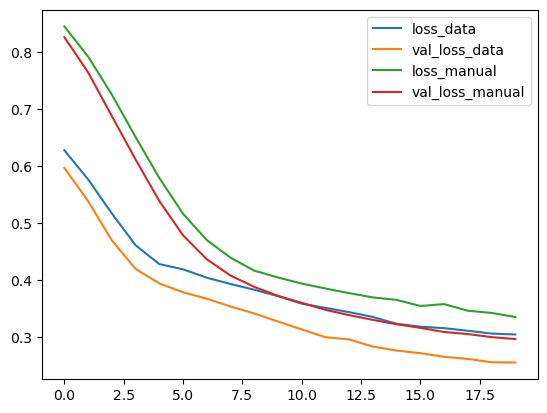

In [46]:
import matplotlib.pyplot as plt

plt.plot(pd.DataFrame(history_data_all['loss']), label='loss_data')
plt.plot(pd.DataFrame(history_data_all['val_loss']), label='val_loss_data')
plt.plot(pd.DataFrame(history_manual_all['loss']), label='loss_manual')
plt.plot(pd.DataFrame(history_manual_all['val_loss']), label='val_loss_manual')

plt.legend()
plt.show()

####  Loss curves for manually selected properties data set 

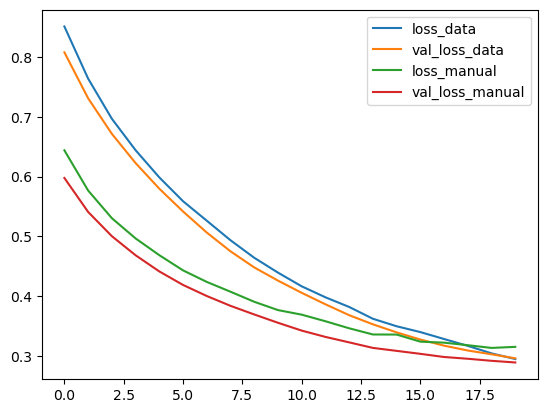

In [47]:
plt.plot(pd.DataFrame(history_data_all_bn['loss']), label='loss_data')
plt.plot(pd.DataFrame(history_data_all_bn['val_loss']), label='val_loss_data')
plt.plot(pd.DataFrame(history_manual_all_bn['loss']), label='loss_manual')
plt.plot(pd.DataFrame(history_manual_all_bn['val_loss']), label='val_loss_manual')

plt.legend()
plt.show()

### Global pruning

In this section we will globally prune all the tested neural networks with the general amount parametr = 0.4

In [48]:
model_data_global        = NeuralNet1(33).to(device)
model_manual_global      = NeuralNet1(12).to(device)
model_data_global_bn     = NeuralNetBN(33).to(device)
model_manual_global_bn   = NeuralNetBN(12).to(device)

print(model_data_global.features)
print(model_data_global_bn.features)

Sequential(
  (ln1): Linear(in_features=33, out_features=25, bias=True)
  (relu1): ReLU(inplace=True)
  (ln2): Linear(in_features=25, out_features=5, bias=True)
  (relu2): ReLU(inplace=True)
  (ln3): Linear(in_features=5, out_features=2, bias=True)
)
Sequential(
  (ln1): Linear(in_features=33, out_features=25, bias=True)
  (bn1): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (ln2): Linear(in_features=25, out_features=5, bias=True)
  (bn2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (ln3): Linear(in_features=5, out_features=2, bias=True)
)


In [49]:
def get_global_prune_parameters(model):
    return ((model.features[0], 'weight'),
        (model.features[2], 'weight'),
        (model.features[4], 'weight'))

def get_global_prune_parameters_bn(model):
    return ((model.features[0], 'weight'),
        (model.features[3], 'weight'),
        (model.features[6], 'weight'))

In [50]:
prune.global_unstructured(
    get_global_prune_parameters(model_data_global),
    pruning_method=prune.L1Unstructured,
    amount=0.4
)

prune.global_unstructured(
    get_global_prune_parameters(model_manual_global),
    pruning_method=prune.L1Unstructured,
    amount=0.4
)

prune.global_unstructured(
    get_global_prune_parameters_bn(model_data_global_bn),
    pruning_method=prune.L1Unstructured,
    amount=0.4
)

prune.global_unstructured(
    get_global_prune_parameters_bn(model_manual_global_bn),
    pruning_method=prune.L1Unstructured,
    amount=0.4
)

Now we can check the sparsity induced in every pruned parameter, which will not be equal to 40% in each layer. 
However, the global sparsity will be (approximately) 40%.

In [51]:
def check_sparsity(model):
    print(
        "Sparsity in ln1.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[0].weight == 0))
            / float(model.features[0].weight.nelement())
        )
    )
    print(
        "Sparsity in ln2.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[2].weight == 0))
            / float(model.features[2].weight.nelement())
        )
    )
    print(
        "Sparsity in ln3.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[4].weight == 0))
            / float(model.features[4].weight.nelement())
        )
    )

    print(
        "Global sparsity: {:.2f}%".format(
            100. * float(
                torch.sum(model.features[0].weight == 0)
                + torch.sum(model.features[2].weight == 0)
                + torch.sum(model.features[4].weight == 0)
            )
            / float(
                model.features[0].weight.nelement()
                + model.features[2].weight.nelement()
                + model.features[4].weight.nelement()
            )
        )
    )

In [53]:
check_sparsity(model_data_global)
check_sparsity(model_manual_global)

Sparsity in ln1.weight: 40.24%
Sparsity in ln2.weight: 41.60%
Sparsity in ln3.weight: 0.00%
Global sparsity: 40.00%
Sparsity in ln1.weight: 34.33%
Sparsity in ln2.weight: 54.40%
Sparsity in ln3.weight: 30.00%
Global sparsity: 40.00%


#### Training pruned models

In [54]:
traintest_data_global = TrainTestModel(model_data_global)
traintest_manual_global = TrainTestModel(model_manual_global)
traintest_data_global_bn = TrainTestModel(model_data_global_bn)
traintest_manual_global_bn = TrainTestModel(model_manual_global_bn)

traintest_data_global.train(data_training_generator, data_validation_generator)

[epoch 0] train loss: 0.579 | train acc: 83.594%
[epoch 0] recall: 0.000 | precision: 0.000
[epoch 0] train loss: 0.558 | train acc: 84.922%
[epoch 0] recall: 0.000 | precision: 0.000
[epoch 0] test loss: 0.510 | test acc: 86.438%
[epoch 0] test recall: 0.000 | test precision: 0.000
[epoch 1] train loss: 0.512 | train acc: 85.000%
[epoch 1] recall: 0.000 | precision: 0.000
[epoch 1] train loss: 0.500 | train acc: 85.625%
[epoch 1] recall: 0.000 | precision: 0.000
[epoch 1] test loss: 0.476 | test acc: 86.438%
[epoch 1] test recall: 0.000 | test precision: 0.000
[epoch 2] train loss: 0.499 | train acc: 83.125%
[epoch 2] recall: 0.000 | precision: 0.000
[epoch 2] train loss: 0.483 | train acc: 84.375%
[epoch 2] recall: 0.000 | precision: 0.000
[epoch 2] test loss: 0.448 | test acc: 86.438%
[epoch 2] test recall: 0.000 | test precision: 0.000
[epoch 3] train loss: 0.452 | train acc: 85.312%
[epoch 3] recall: 0.000 | precision: 0.000
[epoch 3] train loss: 0.456 | train acc: 84.531%
[epoch 

In [55]:
traintest_manual_global.train(manual_training_generator, manual_validation_generator)

[epoch 0] train loss: 0.815 | train acc: 13.125%
[epoch 0] recall: 1.000 | precision: 0.131
[epoch 0] train loss: 0.794 | train acc: 15.312%
[epoch 0] recall: 1.000 | precision: 0.153
[epoch 0] test loss: 0.741 | test acc: 15.946%
[epoch 0] test recall: 1.000 | test precision: 0.139
[epoch 1] train loss: 0.718 | train acc: 26.875%
[epoch 1] recall: 0.887 | precision: 0.183
[epoch 1] train loss: 0.700 | train acc: 43.984%
[epoch 1] recall: 0.718 | precision: 0.183
[epoch 1] test loss: 0.632 | test acc: 85.842%
[epoch 1] test recall: 0.044 | test precision: 0.333
[epoch 2] train loss: 0.619 | train acc: 83.906%
[epoch 2] recall: 0.019 | precision: 0.500
[epoch 2] train loss: 0.596 | train acc: 84.844%
[epoch 2] recall: 0.010 | precision: 0.500
[epoch 2] test loss: 0.532 | test acc: 86.438%
[epoch 2] test recall: 0.000 | test precision: 0.000
[epoch 3] train loss: 0.525 | train acc: 84.531%
[epoch 3] recall: 0.000 | precision: 0.000
[epoch 3] train loss: 0.508 | train acc: 84.531%
[epoch 

In [56]:
traintest_data_global_bn.train(data_training_generator, data_validation_generator)

[epoch 0] train loss: 1.289 | train acc: 14.531%
[epoch 0] recall: 1.000 | precision: 0.145
[epoch 0] train loss: 1.248 | train acc: 15.469%
[epoch 0] recall: 1.000 | precision: 0.155
[epoch 0] test loss: 1.189 | test acc: 13.562%
[epoch 0] test recall: 1.000 | test precision: 0.136
[epoch 1] train loss: 1.161 | train acc: 15.156%
[epoch 1] recall: 1.000 | precision: 0.152
[epoch 1] train loss: 1.140 | train acc: 15.078%
[epoch 1] recall: 1.000 | precision: 0.151
[epoch 1] test loss: 1.094 | test acc: 13.562%
[epoch 1] test recall: 1.000 | test precision: 0.136
[epoch 2] train loss: 1.053 | train acc: 16.562%
[epoch 2] recall: 1.000 | precision: 0.166
[epoch 2] train loss: 1.049 | train acc: 15.547%
[epoch 2] recall: 1.000 | precision: 0.155
[epoch 2] test loss: 1.021 | test acc: 13.562%
[epoch 2] test recall: 1.000 | test precision: 0.136
[epoch 3] train loss: 0.988 | train acc: 15.938%
[epoch 3] recall: 1.000 | precision: 0.159
[epoch 3] train loss: 0.981 | train acc: 15.781%
[epoch 

In [57]:
traintest_manual_global_bn.train(manual_training_generator, manual_validation_generator)

[epoch 0] train loss: 0.905 | train acc: 32.500%
[epoch 0] recall: 0.625 | precision: 0.142
[epoch 0] train loss: 0.878 | train acc: 34.375%
[epoch 0] recall: 0.645 | precision: 0.146
[epoch 0] test loss: 0.810 | test acc: 36.811%
[epoch 0] test recall: 0.670 | test precision: 0.134
[epoch 1] train loss: 0.775 | train acc: 41.250%
[epoch 1] recall: 0.716 | precision: 0.163
[epoch 1] train loss: 0.758 | train acc: 42.500%
[epoch 1] recall: 0.710 | precision: 0.168
[epoch 1] test loss: 0.703 | test acc: 47.541%
[epoch 1] test recall: 0.681 | test precision: 0.161
[epoch 2] train loss: 0.686 | train acc: 45.781%
[epoch 2] recall: 0.726 | precision: 0.177
[epoch 2] train loss: 0.667 | train acc: 50.547%
[epoch 2] recall: 0.722 | precision: 0.189
[epoch 2] test loss: 0.623 | test acc: 59.314%
[epoch 2] test recall: 0.758 | test precision: 0.216
[epoch 3] train loss: 0.604 | train acc: 61.719%
[epoch 3] recall: 0.667 | precision: 0.250
[epoch 3] train loss: 0.599 | train acc: 62.578%
[epoch 

So, the models showed the following results

Simple Fully Connected architecture:

   All properties set: \
    - test loss: 0.242\
    - test acc: 91.356%  
    - test recall:  0.505 \
    - test precision: 0.780 \
   Manually selected set: \
    - test loss: 0.286 \
    - test acc: 90.164% 
    - test recall: 0.407 \
    - test precision: 0.755 
   
Fully Connected architecture with Batch Normalization: \

   All properties set: \
    - test loss: 0.306\
    - test acc: 88.972% 
    - test recall: 0.505 \
    - test precision: 0.613 \
   Manually selected set: \
    - test loss: 0.292 \
    - test acc: 88.227%  
    - test recall: 0.330 \
    - test precision: 0.625 
    


In [58]:
history_data_global = traintest_data_global.get_history()
history_manual_global = traintest_manual_global.get_history()
history_data_global_bn = traintest_data_global_bn.get_history()
history_manual_global_bn = traintest_manual_global_bn.get_history()

####  Loss curves for all properties dataset 

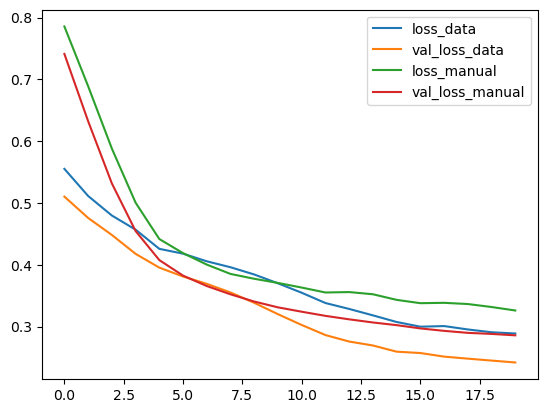

In [59]:
import matplotlib.pyplot as plt

plt.plot(pd.DataFrame(history_data_global['loss']), label='loss_data')
plt.plot(pd.DataFrame(history_data_global['val_loss']), label='val_loss_data')
plt.plot(pd.DataFrame(history_manual_global['loss']), label='loss_manual')
plt.plot(pd.DataFrame(history_manual_global['val_loss']), label='val_loss_manual')

plt.legend()
plt.show()

####  Loss curves for manually selected properties dataset 

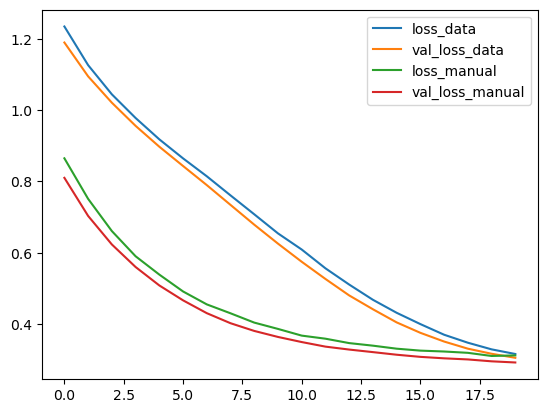

In [60]:
import matplotlib.pyplot as plt

plt.plot(pd.DataFrame(history_data_global_bn['loss']), label='loss_data')
plt.plot(pd.DataFrame(history_data_global_bn['val_loss']), label='val_loss_data')
plt.plot(pd.DataFrame(history_manual_global_bn['loss']), label='loss_manual')
plt.plot(pd.DataFrame(history_manual_global_bn['val_loss']), label='val_loss_manual')

plt.legend()
plt.show()